In [65]:
from tensorflow.python.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import os

In [66]:
input_name = 'x'

In [67]:
def imgs_input_fn(filenames, labels=None, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=1)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [70, 60])
        image.set_shape([70, 60, 1])
        d = dict(zip([input_name], [image])), label
        return d
    if labels is None:
        labels = [0]*len(filenames)
    labels = np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels


In [68]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './morph/colorSubset'

# The directory where we will
# store our smaller dataset
base_dir = './data/male_vs_female_300'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_male_dir = os.path.join(train_dir, 'male')
train_female_dir = os.path.join(train_dir, 'female')
test_male_dir = os.path.join(test_dir, 'male')
test_female_dir = os.path.join(test_dir, 'female')

In [69]:
# os.makedirs(base_dir, exist_ok=True)
# # Directories for our training,
# # validation and test splits
# os.mkdir(train_dir)
# os.mkdir(test_dir)
# # Directory with our training male pictures
# os.mkdir(train_male_dir)
# # Directory with our training female pictures
# os.mkdir(train_female_dir)
# # Directory with our validation male pictures
# os.mkdir(test_male_dir)
# # Directory with our validation female pictures
# os.mkdir(test_female_dir)


In [70]:
# import glob
# images = glob.glob('morph/colorSubset/*.JPG')
# train = images[0:750]
# test = images[751:1000]
# # Copy first 750 male images to train_male_dir
# fnames = [i for i in train if 'M' in i]
# for fname in fnames:
#     _, tail = os.path.split(fname)
#     src = os.path.join(original_dataset_dir, tail)
#     dst = os.path.join(train_male_dir, tail)
#     shutil.copyfile(src, dst)
# # Copy first 750 male images to train_male_dir
# fnames = [i for i in train if 'F' in i]
# for fname in fnames:
#     _, tail = os.path.split(fname)
#     src = os.path.join(original_dataset_dir, tail)
#     dst = os.path.join(train_female_dir, tail)
#     shutil.copyfile(src, dst)
# # Copy next 250 male images to test_male_dir
# fnames = [i for i in test if 'M' in i]
# for fname in fnames:
#     _, tail = os.path.split(fname)
#     src = os.path.join(original_dataset_dir, tail)
#     dst = os.path.join(test_male_dir, tail)
#     shutil.copyfile(src, dst)
# # Copy next 250 female images to train_male_dir
# fnames = [i for i in test if 'F' in i]
# for fname in fnames:
#     _, tail = os.path.split(fname)
#     src = os.path.join(original_dataset_dir, tail)
#     dst = os.path.join(test_female_dir, tail)
#     shutil.copyfile(src, dst)


In [71]:
print('total training male images:', len(os.listdir(train_male_dir)))
print('total training female images:', len(os.listdir(train_female_dir)))
print('total test male images:', len(os.listdir(test_male_dir)))
print('total test female images:', len(os.listdir(test_female_dir)))

total training male images: 156
total training female images: 44
total test male images: 80
total test female images: 18


In [72]:
def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [73]:
MALE_LABEL = 0
FEMALE_LABEL = 1
train_male = [os.path.join(train_male_dir, file_name) for file_name in os.listdir(train_male_dir)]
train_female = [os.path.join(train_female_dir, file_name) for file_name in os.listdir(train_female_dir)]
train_files = train_male + train_female
train_labels = [MALE_LABEL]*len(train_male)+[FEMALE_LABEL]*len(train_female)
train_files, train_labels = unison_shuffled_copies(train_files, train_labels)
test_male = [os.path.join(test_male_dir, file_name) for file_name in os.listdir(test_male_dir)]
test_female = [os.path.join(test_female_dir, file_name) for file_name in os.listdir(test_female_dir)]
test_files = test_male + test_female
test_labels = [MALE_LABEL]*len(test_male)+[FEMALE_LABEL]*len(test_female)
test_files, test_labels = unison_shuffled_copies(test_files, test_labels)

(20, 70, 60, 1)


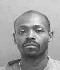

In [80]:
next_batch = imgs_input_fn(test_files, labels=test_labels, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0]['x']

print(x_d.shape)
img = image.array_to_img(x_d[8])
img

In [75]:
x_l = first_batch[1]
x_l.shape

(20, 1)

In [76]:
feature_columns = [tf.feature_column.numeric_column(key='x', shape=4200)]

In [77]:
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                        hidden_units=[100, 50, 25, 10],
                                        n_classes=2,
                                        model_dir='models/DNN4layers')

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'models/DNN4layers', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181904e240>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [78]:
classifier.train(
   input_fn=lambda: imgs_input_fn(filenames=train_files,
                                  labels=train_labels,
                                  perform_shuffle=True,
                                  repeat_count=20,
                                  batch_size=20))

INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from models/DNN4layers/model.ckpt-902


INFO:tensorflow:Saving checkpoints for 903 into models/DNN4layers/model.ckpt.


INFO:tensorflow:loss = 13.173662, step = 903


INFO:tensorflow:global_step/sec: 81.7152


INFO:tensorflow:loss = 12.865875, step = 1003 (1.225 sec)


INFO:tensorflow:Saving checkpoints for 1102 into models/DNN4layers/model.ckpt.


INFO:tensorflow:Loss for final step: 12.926989.


In [79]:
# Evaluate the estimator using our input function.
# We should see our accuracy metric below
# Tweaking with the params of the model, you can get >99% accuracy
evaluation = classifier.evaluate(
    input_fn=lambda: imgs_input_fn(test_files, 
                                   labels=test_labels, 
                                   perform_shuffle=False,
                                   batch_size=1))
print("Evaluation results")
for key in evaluation:
    print("   {}, was: {}".format(key, evaluation[key]))

INFO:tensorflow:Starting evaluation at 2018-03-22-12:44:01


INFO:tensorflow:Restoring parameters from models/DNN4layers/model.ckpt-1102


INFO:tensorflow:Finished evaluation at 2018-03-22-12:44:02


INFO:tensorflow:Saving dict for global step 1102: accuracy = 0.81632656, accuracy_baseline = 0.8163265, auc = 0.5, auc_precision_recall = 0.5918367, average_loss = 0.63242006, global_step = 1102, label/mean = 0.18367347, loss = 0.63242006, prediction/mean = 0.44787952


Evaluation results
   accuracy, was: 0.8163265585899353
   accuracy_baseline, was: 0.8163264989852905
   auc, was: 0.5
   auc_precision_recall, was: 0.59183669090271
   average_loss, was: 0.6324200630187988
   label/mean, was: 0.18367347121238708
   loss, was: 0.6324200630187988
   prediction/mean, was: 0.44787952303886414
   global_step, was: 1102
